### E-tivity 4
### Name: Muhammad Umer Farooq
#### Student ID: 22402098

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
from skopt.space import Real, Categorical, Integer
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Read the data
data_frame = pd.read_csv("seeds.csv")
data_frame.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
# Let's first find if there is any missing values in the data set
data_frame.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

#### We have no missing value, and all of our data is numeric. 
Let's see if we have any outliers in our data.

<AxesSubplot:>

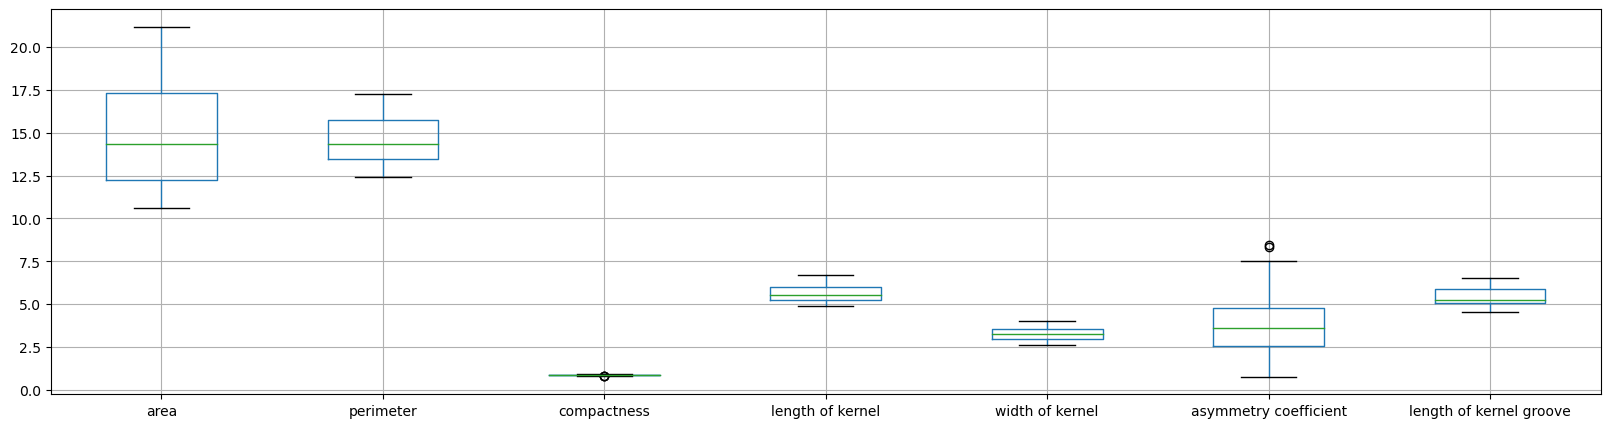

In [4]:
data_frame.loc[:, 'area' : 'length of kernel groove'].boxplot(figsize=(20,5)) 

### Deciding on the Type of Scaler
The data in the data set is not scaled, hence there is a need to scale the data before doing model fitting. The above box and whisker plot shows that only "asymmetry coefficient" column has outliers, and all other features/columns don't have any outlier. Therefore, I will use RobustScaler for feature "asymmetry coefficient". To decide on the type of scaler that should be used on other features, I would plot the distribution to make an informed decision.

<AxesSubplot:title={'center':'Histogram for Feature Length of Kernel Groove'}>

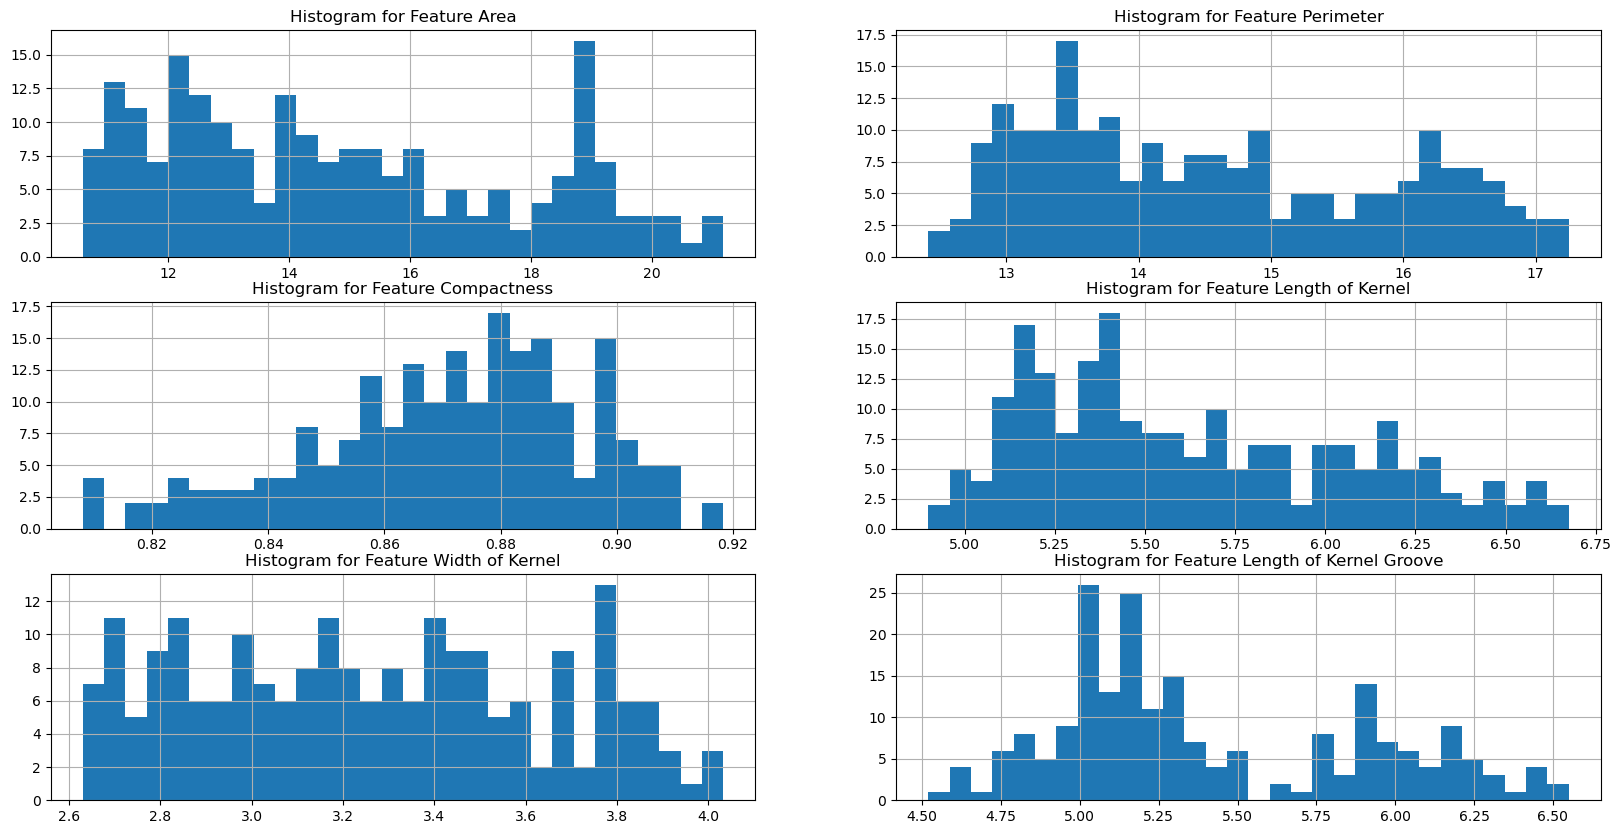

In [5]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(3,2,1)
ax1.set_title("Histogram for Feature Area")
data_frame["area"].hist(bins=30)

ax2 = fig.add_subplot(3,2,2)
ax2.set_title("Histogram for Feature Perimeter")
data_frame["perimeter"].hist(bins=30)

ax3 = fig.add_subplot(3,2,3)
ax3.set_title("Histogram for Feature Compactness")
data_frame["compactness"].hist(bins=30)

ax4 = fig.add_subplot(3,2,4)
ax4.set_title("Histogram for Feature Length of Kernel")
data_frame["length of kernel"].hist(bins=30)

ax5 = fig.add_subplot(3,2,5)
ax5.set_title("Histogram for Feature Width of Kernel")
data_frame["width of kernel"].hist(bins=30)

ax6 = fig.add_subplot(3,2,6)
ax6.set_title("Histogram for Feature Length of Kernel Groove")
data_frame["length of kernel groove"].hist(bins=30)

### Scalers to Use
The above histograms show that the features don't follow Guassian distribution (feature compactness follows a kind of Guassian distribution skewed towards right, however it is not perfect), hence I will use MinMaxScaler for these features as the MinMaxScaler works best for non-Guassian data. The following scalers will be used for the features:

MinMaxScaler - area, perimeter, compactness, length of kernel, width of kernel, and length of kernel groove.  

RobustScaler - asymmetry coefficient


In [6]:
robust = RobustScaler()
value = robust.fit_transform(data_frame["asymmetry coefficient"].values.reshape(-1,1))
print(value.min())

-1.283905312039869


In [7]:
def apply_log_transform(input_data):
    min_value = input_data.min()
    if min_value < 0:
        min_value = (-2)*min_value 
    return np.log(input_data + min_value)

### Transforming type column to Binary
type column is a categorial with values 1, 2, and 3. As we need to convert type to binary, therefore I am transforming the value in type column using the following rule: if the value is the type column is less than or equal to 2, the value is converted to 0, otherwise it is converted to 1. 

Please note there could be other ways to transform type column to binary, but for simplicity I am using the above listed rule.


In [8]:
data_frame.loc[data_frame["type"] == 1, 'type'] = 0 
data_frame.loc[data_frame["type"] == 2, 'type'] = 0 
data_frame.loc[data_frame["type"] == 3, 'type'] = 1
print(data_frame)

      area  perimeter  compactness  length of kernel  width of kernel  \
0    15.26      14.84       0.8710             5.763            3.312   
1    14.88      14.57       0.8811             5.554            3.333   
2    14.29      14.09       0.9050             5.291            3.337   
3    13.84      13.94       0.8955             5.324            3.379   
4    16.14      14.99       0.9034             5.658            3.562   
..     ...        ...          ...               ...              ...   
205  12.19      13.20       0.8783             5.137            2.981   
206  11.23      12.88       0.8511             5.140            2.795   
207  13.20      13.66       0.8883             5.236            3.232   
208  11.84      13.21       0.8521             5.175            2.836   
209  12.30      13.34       0.8684             5.243            2.974   

     asymmetry coefficient  length of kernel groove  type  
0                    2.221                    5.220     0  
1  

In [9]:
outlier_feature = ["asymmetry coefficient"]
non_outlier_features = ["area", "perimeter", "compactness", "length of kernel", "width of kernel", "length of kernel groove"]

# Create a pipeline for preprocessing outlier feature
outlier_transformer = Pipeline(steps = [("scaler", RobustScaler()), ("log", FunctionTransformer(apply_log_transform))])

# Create a pipeline for preprocessing non-outlier features
non_outlier_transformer = Pipeline(steps = [("scaler", MinMaxScaler())])

# Create a column transformer
preprocessor = ColumnTransformer(transformers = [("outlier" , outlier_transformer, outlier_feature), ("non_outlier", non_outlier_transformer, non_outlier_features)])

# Create an overall pipeline
clf = Pipeline(steps = [("preprocessor", preprocessor), ("svm", svm.SVC(probability=True))])

# Let's create test and training data
X = data_frame.drop("type", axis=1).values
y = data_frame["type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)
X_train = pd.DataFrame(X_train, columns = ["area", "perimeter", "compactness", "length of kernel", "width of kernel", "asymmetry coefficient", "length of kernel groove"])
X_test = pd.DataFrame(X_test, columns = ["area", "perimeter", "compactness", "length of kernel", "width of kernel", "asymmetry coefficient", "length of kernel groove"])
y_train = pd.DataFrame(y_train, columns = ["type"])
y_test = pd.DataFrame(y_test, columns = ["type"])

## Grid Search for Best Parameters Search for SVM Classifiers

In [10]:
# prepare a prameter grid to find best SVM Classifier 

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) 

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.982:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'poly'}


### Random Forest Classifier

In [11]:
# Create an overall pipeline with random forest classifier 
clf = Pipeline(steps = [("preprocessor", preprocessor), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.935:
Best parameters:  {'rf__max_depth': 6, 'rf__n_estimators': 10}


## Compare Classifiers on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which we will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, we need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, we take a scale of 100 equally spaced fpr values between 0 and 1.

In [12]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [13]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

Now we will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [14]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

We will use a pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

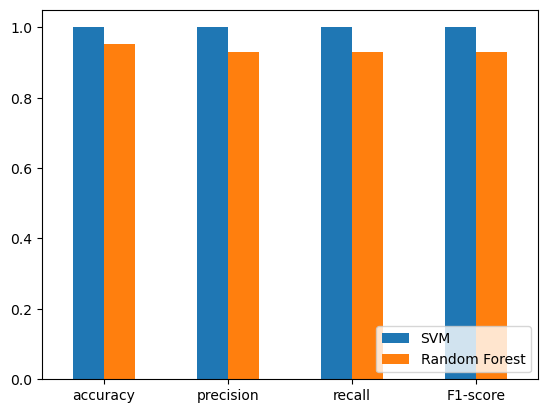

In [15]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

The above bar plot demonstrates that for most of the metrics SVM classifier performs better compared to random forest. For precision metric both classifiers have demonstarted similar performance.

Let's also confirm the results using the ROC curves. 

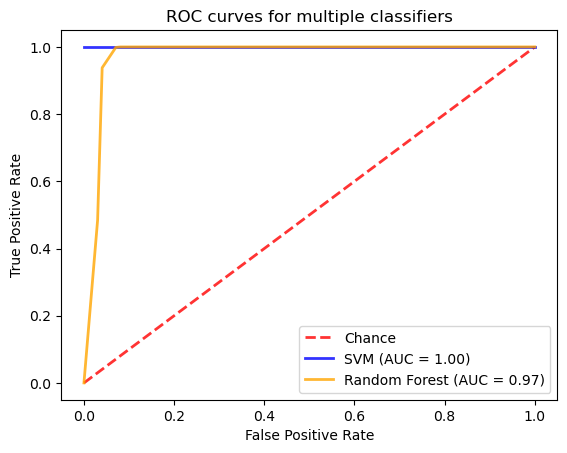

In [16]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The RoC curves also demonstartes that SVM classifier is a slightly better classifier. Moreover, both classifiers demonstarte better performance than a random guess. 

## Training the Final Model
As we need to train another classifier, therefore training of the final model will be done after completing task 2. In task 2, I will compare the SVM classifier, random forest classifer, and MLP classifier. Afterwards, the one that demonstrates the best performace will be selected for the final model training.  

## Task 2

For this task, I have decided to train a MLP classifier. Afterwards, the plan is to compare MLP classifier performance with the SVM and random forest classifier’s performance. Finally, the best among the evaluated classifiers will be used to train a model using the complete data set, and the trained model along with the pipeline will be stored on the disk for future use.

In [17]:
# As with the other classifiers there are a number of hyper-parameters associated with MLP. 
# First, we need to find optimal values for different hyper-parameters.
# Here, the goal is to find optimal hyper-paramters from a subset of possible values.

# Create a pipeline with MLP classifier
clf = Pipeline(steps = [("preprocessor", preprocessor), ('mlp', MLPClassifier())])
parameters_to_tune = {
    'mlp__hidden_layer_sizes':[2,3,4,6,7],
    'mlp__activation': ['identity','logistic','tanh','relu'],
    'mlp__solver': ['lbfgs','sgd','adam'],
    'mlp__learning_rate':['constant','invscaling','adaptive'],
    }

search = GridSearchCV(clf, parameters_to_tune, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
MLP_best_params = search.best_params_
MLP_best_model = search.best_estimator_

Best CV score = 0.982:
Best parameters:  {'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': 4, 'mlp__learning_rate': 'adaptive', 'mlp__solver': 'lbfgs'}


### Evaluation of MLP Classifier on Test Set

In [18]:
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, MLP_best_model)

### Comparison of Classifiers
#### - SVM
#### - Random Forest
#### - MLP

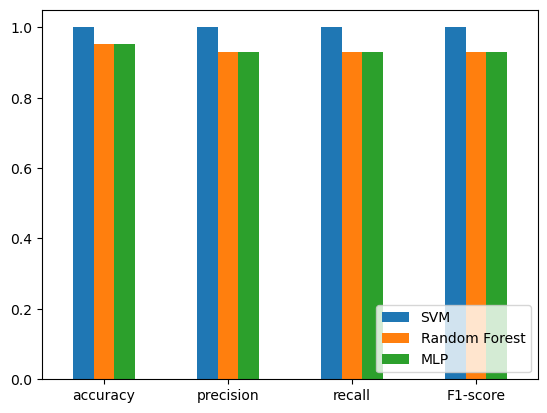

In [19]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP' : MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

Let's plot RoC curve to obtain a further confirmation of the results shown in the above bar plot.

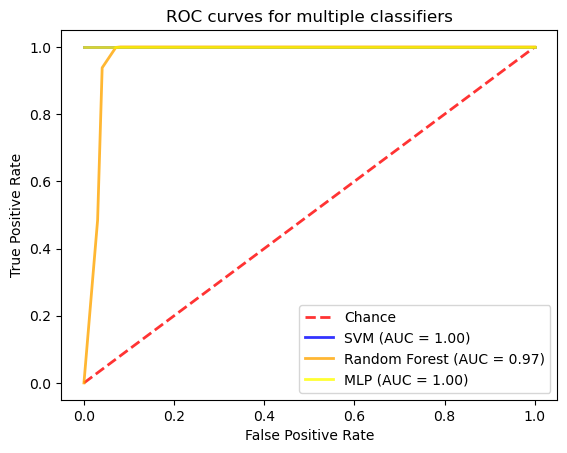

In [20]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='yellow', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The results shown in above figures demonstrate that SVM classifier superior performance compared to the other classifier evalauted here. Moreover, overall Random Forest and MLP have demonstarted similar performace. In light of the above, results I will prepare the final classifier on the complete data set using the SVM classifier, and store the classifier on the disk for future use. 

### Final Model Training

In [24]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

X = pd.DataFrame(X, columns = ["area", "perimeter", "compactness", "length of kernel", "width of kernel", "asymmetry coefficient", "length of kernel groove"])
y = pd.DataFrame(y, columns = ["type"])
pipe = make_pipeline(preprocessor, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

# Store the model on disk
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))